# Take Home Exam - Dry Run

**EAS 510 - Basics of AI**  
**November 10, 2025**

## Introduction

Welcome to the **Take Home Exam Dry Run** for Basics of AI (Modules 9-14)!

This notebook serves as an interactive practice session to help you prepare for the actual take home exam. We will work through example problems covering:

- **K-Means Clustering**
- **Dimensionality Reduction (PCA)**

### Instructions:
- This is a collaborative, in-class exercise
- We'll step through each section together
- Try to work through the problems before we reveal solutions
- Ask questions as we go!

## 1. Library Imports

Before we begin, let's import all the necessary libraries we'll need for our machine learning examples.

In [77]:
# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model evaluation and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Obtaining the Data

We'll use Portland, Oregon Airbnb data from Inside Airbnb. Portland is perfect for our analysis because it has Portland State University downtown but isn't overwhelmed by major tourist attractions, making clustering patterns clearer.

Let's download and explore the dataset:

In [122]:
import requests
import gzip
import io
from urllib.request import urlopen

# 1. Download the gzipped CSV file
url = "https://data.insideairbnb.com/united-states/or/portland/2025-09-06/data/listings.csv.gz"

print("Downloading Portland Airbnb data...")
response = requests.get(url)

if response.status_code == 200:
    print(f"✓ Successfully downloaded {len(response.content):,} bytes")
    
    # 2. Open the gzipped file
    with gzip.open(io.BytesIO(response.content), 'rt', encoding='utf-8') as f:
        # 3. Load into a DataFrame
        portland_listings = pd.read_csv(f)
    
    print(f"✓ Dataset loaded with {portland_listings.shape[0]:,} listings and {portland_listings.shape[1]} columns")
    
else:
    print(f"✗ Failed to download data. Status code: {response.status_code}")
    
# 4. Show the columns available
print("\n" + "="*60)
print("AVAILABLE COLUMNS:")
print("="*60)
for i, col in enumerate(portland_listings.columns, 1):
    print(f"{i:2d}. {col}")
    
print(f"\nTotal columns: {len(portland_listings.columns)}")

# 5. Show the first five rows
print("\n" + "="*60) 
print("FIRST 5 ROWS:")
print("="*60)

# Display key columns from first 5 rows
key_columns = ['id', 'name', 'neighbourhood_cleansed', 'room_type', 'price', 'accommodates', 'bedrooms', 'review_scores_rating']
available_key_columns = [col for col in key_columns if col in portland_listings.columns]

if available_key_columns:
    print(portland_listings[available_key_columns].head().to_string(index=False))
else:
    # Fallback to first 8 columns
    print(portland_listings.iloc[:5, :8].to_string(index=False))

✓ Successfully downloaded 2,936,980 bytes
✓ Dataset loaded with 4,425 listings and 79 columns

AVAILABLE COLUMNS:
 1. id
 2. listing_url
 3. scrape_id
 4. last_scraped
 5. source
 6. name
 7. description
 8. neighborhood_overview
 9. picture_url
10. host_id
11. host_url
12. host_name
13. host_since
14. host_location
15. host_about
16. host_response_time
17. host_response_rate
18. host_acceptance_rate
19. host_is_superhost
20. host_thumbnail_url
21. host_picture_url
22. host_neighbourhood
23. host_listings_count
24. host_total_listings_count
25. host_verifications
26. host_has_profile_pic
27. host_identity_verified
28. neighbourhood
29. neighbourhood_cleansed
30. neighbourhood_group_cleansed
31. latitude
32. longitude
33. property_type
34. room_type
35. accommodates
36. bathrooms
37. bathrooms_text
38. bedrooms
39. beds
40. amenities
41. price
42. minimum_nights
43. maximum_nights
44. minimum_minimum_nights
45. maximum_minimum_nights
46. minimum_maximum_nights
47. maximum_maximum_nights

In [123]:
# Display first 5 rows with key columns for readability
key_columns = ['id', 'name', 'neighbourhood_cleansed', 'latitude', 'longitude', 
               'room_type', 'price', 'minimum_nights', 'availability_365']

# Check which key columns exist in the dataset
existing_key_columns = [col for col in key_columns if col in portland_listings.columns]

print("First 5 rows with key columns:")
print("="*80)
if existing_key_columns:
    display_df = portland_listings[existing_key_columns].head()
    print(display_df.to_string(index=False))
else:
    # If key columns don't exist, show first few columns
    display_df = portland_listings.iloc[:, :8].head()  # First 8 columns only
    print(display_df.to_string(index=False))

print(f"\nDataset Info:")
print(f"Shape: {portland_listings.shape}")
print(f"Memory usage: {portland_listings.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Show a few more useful columns separately
print(f"\nAdditional Key Columns:")
print("="*50)
additional_cols = ['accommodates', 'bedrooms', 'beds', 'review_scores_rating', 
                  'number_of_reviews', 'property_type']
existing_additional = [col for col in additional_cols if col in portland_listings.columns]

if existing_additional:
    add_df = portland_listings[existing_additional].head()
    print(add_df.to_string(index=False))

First 5 rows with key columns:
   id                                               name neighbourhood_cleansed  latitude  longitude       room_type   price  minimum_nights  availability_365
37676                Mt. Hood View in the Pearl District                  Pearl  45.52564 -122.68273 Entire home/apt $159.00              30               339
61893                             Perfect Portland Place           Goose Hollow  45.52258 -122.69955 Entire home/apt $130.00              30               214
67036              Historic Home Located in Central City       Sullivan's Gulch  45.53103 -122.64448 Entire home/apt $354.00               4               317
77522 Spacious Suite in Eastmoreland/SE. Hot Tub Dogs OK           Eastmoreland  45.47086 -122.63273 Entire home/apt  $76.00              30               361
93613               Sunny Queen Room in FUN Alberta Arts                  Sabin  45.55536 -122.65106    Private room  $81.00              30               335

Dataset Info:


## 3. Market Segmentation Analysis with K-Means

Now let's perform market segmentation clustering using three key numeric features:
- **Price**: Daily rental cost
- **Accommodates**: Number of guests the property can host  
- **Review Scores Rating**: Overall guest satisfaction

This will help us identify distinct market segments in Portland's Airbnb market.

In [124]:
# Step 1: Data Preparation
import re

# Convert price from string to numeric (remove $ and convert to float)
portland_listings['price_numeric'] = portland_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Create our feature matrix for clustering
features_for_clustering = ['price_numeric', 'accommodates', 'review_scores_rating']

# Check for missing values and data quality
print("Missing values in clustering features:")
for col in features_for_clustering:
    missing = portland_listings[col].isna().sum()
    print(f"  {col}: {missing} missing values ({missing/len(portland_listings)*100:.1f}%)")

# Remove rows with missing values in any of our clustering features
clustering_data = portland_listings[features_for_clustering].dropna()
print(f"\nOriginal dataset: {len(portland_listings):,} listings")
print(f"After removing missing values: {len(clustering_data):,} listings")

# Basic statistics
print(f"\nFeature Statistics:")
print(clustering_data.describe())

Missing values in clustering features:
  price_numeric: 627 missing values (14.2%)
  accommodates: 0 missing values (0.0%)
  review_scores_rating: 587 missing values (13.3%)

Original dataset: 4,425 listings
After removing missing values: 3,303 listings

Feature Statistics:
       price_numeric  accommodates  review_scores_rating
count    3303.000000   3303.000000           3303.000000
mean      243.048138      3.591281              4.862552
std      2236.664805      2.184566              0.268120
min        20.000000      1.000000              1.000000
25%        81.000000      2.000000              4.830000
50%       107.000000      3.000000              4.930000
75%       155.000000      4.000000              4.990000
max     50000.000000     16.000000              5.000000


In [125]:
# Step 2: Feature Scaling (Essential for K-means!)
from sklearn.preprocessing import StandardScaler

# Scale features to have mean=0 and std=1
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

print("Feature scaling applied:")
print(f"Original data shape: {clustering_data.shape}")
print(f"Scaled data shape: {clustering_data_scaled.shape}")

# Show the effect of scaling
print(f"\nBefore scaling - Feature ranges:")
for i, col in enumerate(features_for_clustering):
    print(f"  {col}: {clustering_data[col].min():.2f} to {clustering_data[col].max():.2f}")
    
print(f"\nAfter scaling - Feature ranges:")
for i, col in enumerate(features_for_clustering):
    print(f"  {col}: {clustering_data_scaled[:, i].min():.2f} to {clustering_data_scaled[:, i].max():.2f}")

Feature scaling applied:
Original data shape: (3303, 3)
Scaled data shape: (3303, 3)

Before scaling - Feature ranges:
  price_numeric: 20.00 to 50000.00
  accommodates: 1.00 to 16.00
  review_scores_rating: 1.00 to 5.00

After scaling - Feature ranges:
  price_numeric: -0.10 to 22.25
  accommodates: -1.19 to 5.68
  review_scores_rating: -14.41 to 0.51


Calculating WCSS for different k values...
k=1: WCSS = 9909.00
k=2: WCSS = 6626.62
k=3: WCSS = 4768.98
k=4: WCSS = 3014.77
k=5: WCSS = 2098.44
k=6: WCSS = 1376.27
k=7: WCSS = 1138.20
k=8: WCSS = 924.94
k=9: WCSS = 801.14
k=10: WCSS = 679.13


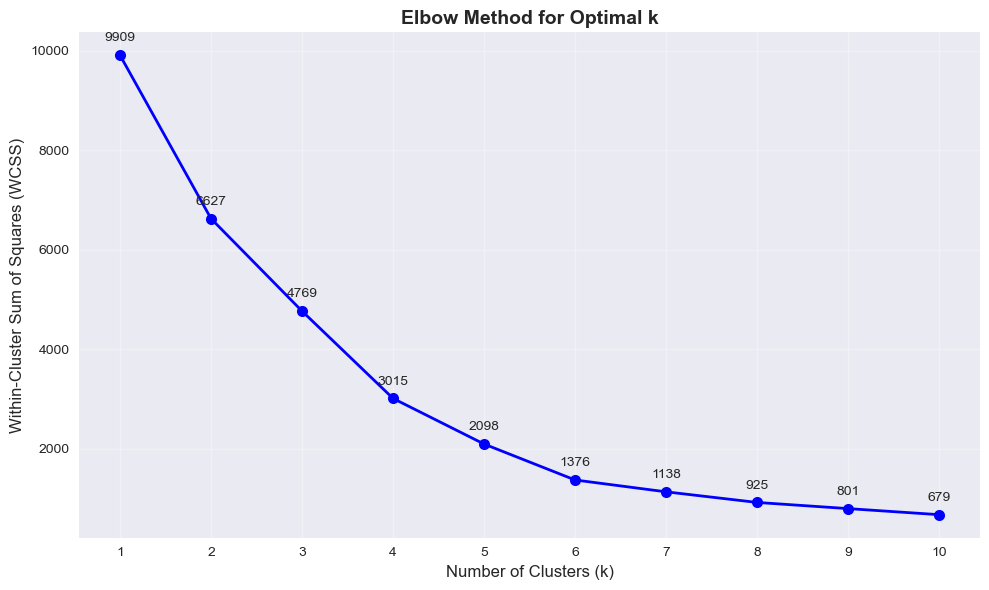


Rate of WCSS decrease:
k=1 to k=2: decrease = 3282.38
k=2 to k=3: decrease = 1857.64
k=3 to k=4: decrease = 1754.21
k=4 to k=5: decrease = 916.33
k=5 to k=6: decrease = 722.17
k=6 to k=7: decrease = 238.06
k=7 to k=8: decrease = 213.27
k=8 to k=9: decrease = 123.80
k=9 to k=10: decrease = 122.01

Recommendation: Look for the 'elbow' where the rate of decrease slows significantly.


In [126]:
# Step 3: Determine Optimal Number of Clusters (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for different numbers of clusters
wcss_values = []
k_range = range(1, 11)

print("Calculating WCSS for different k values...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    wcss_values.append(kmeans.inertia_)
    print(f"k={k}: WCSS = {kmeans.inertia_:.2f}")

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss_values, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Annotate points with WCSS values
for i, (k, wcss) in enumerate(zip(k_range, wcss_values)):
    plt.annotate(f'{wcss:.0f}', (k, wcss), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Calculate the rate of decrease to help identify the elbow
print(f"\nRate of WCSS decrease:")
for i in range(1, len(wcss_values)):
    decrease = wcss_values[i-1] - wcss_values[i]
    print(f"k={i} to k={i+1}: decrease = {decrease:.2f}")
    
print(f"\nRecommendation: Look for the 'elbow' where the rate of decrease slows significantly.")

In [127]:
# Step 4: Apply K-means with chosen k (using k=6 based on elbow analysis)
optimal_k = 6  # Based on elbow method - significant drop from 722 to 238 at k=6

# Fit K-means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(clustering_data_scaled)

# Add cluster labels to our original data
clustering_results = clustering_data.copy()
clustering_results['Cluster'] = cluster_labels

print(f"K-means clustering completed with k={optimal_k}")
print(f"Final WCSS: {kmeans_final.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(clustering_data_scaled, cluster_labels):.3f}")

# Analyze cluster sizes
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster_id, count in cluster_counts.items():
    percentage = count/len(cluster_labels)*100
    print(f"  Cluster {cluster_id}: {count:,} listings ({percentage:.1f}%)")

print(f"\nNote: k=6 was chosen because the WCSS decrease slowed significantly")
print(f"from 722 (k=5→k=6) to 238 (k=6→k=7), indicating the optimal elbow point.")

K-means clustering completed with k=6
Final WCSS: 1376.27
Silhouette Score: 0.531

Cluster sizes:
  Cluster 0: 1,591 listings (48.2%)
  Cluster 1: 185 listings (5.6%)
  Cluster 2: 7 listings (0.2%)
  Cluster 3: 1,298 listings (39.3%)
  Cluster 4: 17 listings (0.5%)
  Cluster 5: 205 listings (6.2%)

Note: k=6 was chosen because the WCSS decrease slowed significantly
from 722 (k=5→k=6) to 238 (k=6→k=7), indicating the optimal elbow point.


In [128]:
# Step 5: Detailed Cluster Member Evaluation

print("="*80)
print("DETAILED CLUSTER MEMBER ANALYSIS")
print("="*80)

# For each cluster, analyze the characteristics of its members
for cluster_id in range(optimal_k):
    print(f"\n{'='*20} CLUSTER {cluster_id} ANALYSIS {'='*20}")
    
    # Get all members of this cluster
    cluster_members = clustering_results[clustering_results['Cluster'] == cluster_id]
    cluster_size = len(cluster_members)
    
    print(f"Cluster Size: {cluster_size:,} listings ({cluster_size/len(clustering_results)*100:.1f}%)")
    
    # Statistical summary for this cluster
    print(f"\nStatistical Summary:")
    print(f"  Price: ${cluster_members['price_numeric'].mean():.2f} (avg) | ${cluster_members['price_numeric'].median():.2f} (median)")
    print(f"         Range: ${cluster_members['price_numeric'].min():.2f} - ${cluster_members['price_numeric'].max():.2f}")
    
    print(f"  Accommodates: {cluster_members['accommodates'].mean():.1f} (avg) | {cluster_members['accommodates'].median():.1f} (median)")
    print(f"                Range: {cluster_members['accommodates'].min():.0f} - {cluster_members['accommodates'].max():.0f} guests")
    
    print(f"  Rating: {cluster_members['review_scores_rating'].mean():.2f} (avg) | {cluster_members['review_scores_rating'].median():.2f} (median)")
    print(f"          Range: {cluster_members['review_scores_rating'].min():.2f} - {cluster_members['review_scores_rating'].max():.2f}")
    
    # Show a few representative examples from this cluster
    print(f"\nRepresentative Examples (3 random listings):")
    print("-" * 60)
    sample_members = cluster_members.sample(min(3, cluster_size), random_state=42)
    
    for idx, (_, listing) in enumerate(sample_members.iterrows(), 1):
        print(f"  Example {idx}:")
        print(f"    Price: ${listing['price_numeric']:.2f} | Accommodates: {listing['accommodates']:.0f} | Rating: {listing['review_scores_rating']:.2f}")
    
    # Suggest cluster interpretation
    avg_price = cluster_members['price_numeric'].mean()
    avg_accommodates = cluster_members['accommodates'].mean()
    avg_rating = cluster_members['review_scores_rating'].mean()
    
    print(f"\nCluster Interpretation:")
    if avg_price < 80 and avg_accommodates <= 2:
        interpretation = "💰 Budget Solo/Couple Market"
    elif avg_price < 150 and avg_accommodates <= 4:
        interpretation = "🏠 Mid-Range Small Group Market"
    elif avg_price >= 300:
        interpretation = "✨ Premium/Luxury Market"
    elif avg_accommodates >= 8:
        interpretation = "👨‍👩‍👧‍👦 Large Family/Group Market"
    elif avg_accommodates <= 2 and avg_rating >= 4.8:
        interpretation = "⭐ High-Quality Intimate Market"
    else:
        interpretation = "🎯 Standard Market Segment"
        
    print(f"  Suggested Category: {interpretation}")

print(f"\n" + "="*80)
print("SUMMARY: You can use these cluster characteristics to:")
print("1. Target marketing campaigns to specific segments")  
print("2. Set competitive pricing strategies")
print("3. Identify underserved market niches")
print("4. Optimize property features for target segments")
print("="*80)

DETAILED CLUSTER MEMBER ANALYSIS

==================== CLUSTER 0 ANALYSIS ====================
Cluster Size: 1,591 listings (48.2%)

Statistical Summary:
  Price: $96.84 (avg) | $87.00 (median)
         Range: $20.00 - $1335.00
  Accommodates: 2.1 (avg) | 2.0 (median)
                Range: 1 - 3 guests
  Rating: 4.91 (avg) | 4.94 (median)
          Range: 4.60 - 5.00

Representative Examples (3 random listings):
------------------------------------------------------------
  Example 1:
    Price: $30.00 | Accommodates: 1 | Rating: 4.60
  Example 2:
    Price: $86.00 | Accommodates: 2 | Rating: 4.98
  Example 3:
    Price: $73.00 | Accommodates: 2 | Rating: 4.89

Cluster Interpretation:
  Suggested Category: 🏠 Mid-Range Small Group Market

==================== CLUSTER 1 ANALYSIS ====================
Cluster Size: 185 listings (5.6%)

Statistical Summary:
  Price: $424.86 (avg) | $360.00 (median)
         Range: $80.00 - $1350.00
  Accommodates: 10.2 (avg) | 10.0 (median)
               

In [130]:
# Step 5A: Cluster Comparison Table

print("="*80)
print("CLUSTER COMPARISON TABLE")
print("="*80)

# Create a summary table comparing all clusters
cluster_summary = clustering_results.groupby('Cluster').agg({
    'price_numeric': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'accommodates': ['mean', 'median', 'min', 'max'],
    'review_scores_rating': ['mean', 'median', 'min', 'max']
}).round(2)

# Flatten column names
cluster_summary.columns = ['_'.join(col) for col in cluster_summary.columns]

# Display the summary table
print("Summary Statistics by Cluster:")
print(cluster_summary.to_string())

# Create a simplified comparison table
print(f"\n" + "="*80)
print("SIMPLIFIED CLUSTER COMPARISON")
print("="*80)

comparison_data = []
for cluster_id in range(optimal_k):
    cluster_data = clustering_results[clustering_results['Cluster'] == cluster_id]
    comparison_data.append({
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Pct': f"{len(cluster_data)/len(clustering_results)*100:.1f}%",
        'Avg_Price': f"${cluster_data['price_numeric'].mean():.0f}",
        'Avg_Guests': f"{cluster_data['accommodates'].mean():.1f}",
        'Avg_Rating': f"{cluster_data['review_scores_rating'].mean():.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\nKey Insights:")
print(f"• Largest clusters: {comparison_df.nlargest(2, 'Size')['Cluster'].tolist()}")
print(f"• Highest priced: Cluster {clustering_results.groupby('Cluster')['price_numeric'].mean().idxmax()}")
print(f"• Highest rated: Cluster {clustering_results.groupby('Cluster')['review_scores_rating'].mean().idxmax()}")
print(f"• Largest capacity: Cluster {clustering_results.groupby('Cluster')['accommodates'].mean().idxmax()}")

CLUSTER COMPARISON TABLE
Summary Statistics by Cluster:
         price_numeric_count  price_numeric_mean  price_numeric_median  price_numeric_std  price_numeric_min  price_numeric_max  accommodates_mean  accommodates_median  accommodates_min  accommodates_max  review_scores_rating_mean  review_scores_rating_median  review_scores_rating_min  review_scores_rating_max
Cluster                                                                                                                                                                                                                                                                                                                
0                       1591               96.84                  87.0              65.18               20.0             1335.0               2.10                  2.0                 1                 3                       4.91                         4.94                      4.60                      5.00
1       

## 4. Principal Component Analysis (PCA) for Dimensionality Reduction

Now let's explore using PCA to reduce dimensionality and identify the main patterns in our data using **only numeric features**. We'll then use the principal components for clustering to see if it produces different (and potentially better) market segments.

In [131]:
# Step 1: Select ONLY Numeric Features for PCA

# Define comprehensive set of NUMERIC-ONLY features for PCA analysis
pca_features = [
    # Property size and characteristics (ALL NUMERIC)
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    
    # Location coordinates (NUMERIC)
    'latitude', 'longitude',
    
    # Pricing (NUMERIC after conversion)
    'price_numeric',
    
    # Booking patterns (ALL NUMERIC)
    'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365',
    
    # Review performance (ALL NUMERIC - ratings and counts)
    'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    
    # Revenue/business metrics (NUMERIC if available)
    'estimated_revenue_l365d', 'estimated_occupancy_l365d',
    
    # Host characteristics (NUMERIC counts)
    'host_listings_count', 'calculated_host_listings_count'
]

# Check which NUMERIC features actually exist in our dataset
available_pca_features = [col for col in pca_features if col in portland_listings.columns]

print("NUMERIC Features Selected for PCA:")
for i, feature in enumerate(available_pca_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\nTotal NUMERIC features for PCA: {len(available_pca_features)}")

# Verify all features are actually numeric
print(f"\nData types verification:")
for feature in available_pca_features[:10]:  # Show first 10
    dtype = portland_listings[feature].dtype
    print(f"  {feature}: {dtype}")

# Create PCA dataset (removing rows with any missing values)
pca_data = portland_listings[available_pca_features].dropna()
print(f"\nDataset size after removing missing values: {len(pca_data):,} listings")
print(f"NUMERIC features retained: {len(available_pca_features)} columns")
print(f"Note: PCA requires ALL features to be numeric - no categorical data!")

NUMERIC Features Selected for PCA:
   1. accommodates
   2. bedrooms
   3. beds
   4. bathrooms
   5. latitude
   6. longitude
   7. price_numeric
   8. minimum_nights
   9. availability_30
  10. availability_60
  11. availability_90
  12. availability_365
  13. number_of_reviews
  14. number_of_reviews_ltm
  15. review_scores_rating
  16. review_scores_accuracy
  17. review_scores_cleanliness
  18. review_scores_checkin
  19. review_scores_communication
  20. review_scores_location
  21. review_scores_value
  22. estimated_revenue_l365d
  23. estimated_occupancy_l365d
  24. host_listings_count
  25. calculated_host_listings_count

Total NUMERIC features for PCA: 25

Data types verification:
  accommodates: int64
  bedrooms: float64
  beds: float64
  bathrooms: float64
  latitude: float64
  longitude: float64
  price_numeric: float64
  minimum_nights: int64
  availability_30: int64
  availability_60: int64

Dataset size after removing missing values: 3,298 listings
NUMERIC features ret

In [132]:
# Step 2: Standardize Features and Apply PCA

from sklearn.decomposition import PCA

# Standardize features (ESSENTIAL for PCA with numeric data!)
pca_scaler = StandardScaler()
pca_data_scaled = pca_scaler.fit_transform(pca_data)

print("Feature standardization completed for NUMERIC data.")
print(f"Scaled data shape: {pca_data_scaled.shape}")

# Apply PCA with all components initially to see explained variance
pca_full = PCA()
pca_full.fit(pca_data_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

print(f"\nPCA Results:")
print(f"Total components: {len(pca_full.explained_variance_ratio_)}")

# Show variance explained by first 10 components
print(f"\nExplained Variance by Component:")
for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca_full.explained_variance_ratio_[i]:.3f} ({pca_full.explained_variance_ratio_[i]*100:.1f}%)")

# Find number of components needed for 80%, 90%, 95% of variance
for threshold in [0.8, 0.9, 0.95]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"\nComponents needed for {threshold*100:.0f}% variance: {n_components}")
    print(f"  Actual variance captured: {cumulative_variance[n_components-1]:.3f} ({cumulative_variance[n_components-1]*100:.1f}%)")

# Determine optimal number of components (let's use 95% threshold)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nRecommended components: {optimal_components} (captures {cumulative_variance[optimal_components-1]*100:.1f}% of variance)")
print(f"Dimensionality reduction: {len(available_pca_features)} features → {optimal_components} components")

Feature standardization completed for NUMERIC data.
Scaled data shape: (3298, 25)

PCA Results:
Total components: 25

Explained Variance by Component:
  PC1: 0.217 (21.7%)
  PC2: 0.133 (13.3%)
  PC3: 0.113 (11.3%)
  PC4: 0.094 (9.4%)
  PC5: 0.091 (9.1%)
  PC6: 0.048 (4.8%)
  PC7: 0.040 (4.0%)
  PC8: 0.034 (3.4%)
  PC9: 0.032 (3.2%)
  PC10: 0.026 (2.6%)

Components needed for 80% variance: 9
  Actual variance captured: 0.803 (80.3%)

Components needed for 90% variance: 14
  Actual variance captured: 0.911 (91.1%)

Components needed for 95% variance: 18
  Actual variance captured: 0.959 (95.9%)

Recommended components: 18 (captures 95.9% of variance)
Dimensionality reduction: 25 features → 18 components


In [133]:
# Step 3: Interpret Principal Components

# Fit PCA with optimal number of components
pca_optimal = PCA(n_components=optimal_components)
pca_transformed = pca_optimal.fit_transform(pca_data_scaled)

print("="*80)
print("PRINCIPAL COMPONENT INTERPRETATION")
print("="*80)

# Analyze what each component represents
component_names = []
for i in range(optimal_components):
    print(f"\n--- PRINCIPAL COMPONENT {i+1} ---")
    print(f"Explains {pca_optimal.explained_variance_ratio_[i]*100:.1f}% of variance")
    
    # Get feature loadings for this component
    loadings = pca_optimal.components_[i]
    
    # Find features with highest absolute loadings (most important)
    feature_importance = [(available_pca_features[j], abs(loadings[j]), loadings[j]) 
                         for j in range(len(available_pca_features))]
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    print("Top contributing NUMERIC features:")
    for feature, abs_loading, loading in feature_importance[:5]:
        direction = "+" if loading > 0 else "-"
        print(f"  {direction} {feature}: {abs_loading:.3f}")
    
    # Suggest interpretation based on top features
    top_features = [f[0] for f in feature_importance[:3]]
    
    if any('review_scores' in f for f in top_features):
        if any('accommodates' in f or 'beds' in f for f in top_features):
            interpretation = "Quality & Size Factor"
        else:
            interpretation = "Quality Factor"
    elif any('beds' in f or 'accommodates' in f or 'bedrooms' in f for f in top_features):
        interpretation = "Property Size Factor"
    elif any('price' in f.lower() or 'revenue' in f for f in top_features):
        interpretation = "Pricing/Revenue Factor" 
    elif any('latitude' in f or 'longitude' in f for f in top_features):
        interpretation = "Geographic Factor"
    elif any('availability' in f or 'minimum_nights' in f for f in top_features):
        interpretation = "Booking Strategy Factor"
    elif any('host' in f or 'reviews' in f for f in top_features):
        interpretation = "Host Experience Factor"
    else:
        interpretation = "Mixed Factor"
    
    component_names.append(interpretation)
    print(f"Suggested interpretation: {interpretation}")

print(f"\n" + "="*80)
print("SUMMARY OF PRINCIPAL COMPONENTS (from NUMERIC features):")
for i, name in enumerate(component_names):
    variance_pct = pca_optimal.explained_variance_ratio_[i]*100
    print(f"PC{i+1}: {name} ({variance_pct:.1f}% variance)")
print("="*80)

print(f"\nConclusion: PCA has reduced {len(available_pca_features)} numeric features")
print(f"down to {optimal_components} principal components while preserving")  
print(f"{cumulative_variance[optimal_components-1]*100:.1f}% of the original information!")

PRINCIPAL COMPONENT INTERPRETATION

--- PRINCIPAL COMPONENT 1 ---
Explains 21.7% of variance
Top contributing NUMERIC features:
  + review_scores_rating: 0.380
  + review_scores_accuracy: 0.373
  + review_scores_value: 0.371
  + review_scores_communication: 0.341
  + review_scores_cleanliness: 0.335
Suggested interpretation: Quality Factor

--- PRINCIPAL COMPONENT 2 ---
Explains 13.3% of variance
Top contributing NUMERIC features:
  + accommodates: 0.428
  + bedrooms: 0.425
  + beds: 0.408
  + bathrooms: 0.346
  + availability_60: 0.264
Suggested interpretation: Property Size Factor

--- PRINCIPAL COMPONENT 3 ---
Explains 11.3% of variance
Top contributing NUMERIC features:
  + availability_90: 0.437
  + availability_60: 0.433
  + availability_30: 0.394
  - bedrooms: 0.263
  - beds: 0.258
Suggested interpretation: Booking Strategy Factor

--- PRINCIPAL COMPONENT 4 ---
Explains 9.4% of variance
Top contributing NUMERIC features:
  + price_numeric: 0.586
  + estimated_revenue_l365d: 0.55

## 5. PCA-Based K-Means Clustering Approaches

Based on our PCA analysis, let's explore two sophisticated clustering approaches that leverage the principal components to discover market segments that traditional feature-based clustering might miss.

### Approach 1: Quality × Size Clustering (2D)

Let's cluster using the two dominant principal components: PC1 (Quality Factor) and PC2 (Property Size Factor), which together explain 35% of the total variance.

In [134]:
# Approach 1: Quality × Size Clustering (2D)

# Use the first 2 principal components (Quality and Size factors)
pca_2d_data = pca_transformed[:, :2]  # PC1 and PC2 only

print("="*80)
print("APPROACH 1: QUALITY × SIZE CLUSTERING (2D)")
print("="*80)
print(f"Using PC1 (Quality Factor) + PC2 (Property Size Factor)")
print(f"Combined variance explained: {(pca_optimal.explained_variance_ratio_[0] + pca_optimal.explained_variance_ratio_[1])*100:.1f}%")
print(f"Clustering data shape: {pca_2d_data.shape}")

# Determine optimal k using elbow method
wcss_2d = []
silhouette_2d = []
k_range_2d = range(2, 9)

print(f"\nFinding optimal k for 2D clustering...")
for k in k_range_2d:
    kmeans_2d = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_2d.fit(pca_2d_data)
    wcss_2d.append(kmeans_2d.inertia_)
    sil_score = silhouette_score(pca_2d_data, kmeans_2d.labels_)
    silhouette_2d.append(sil_score)
    print(f"  k={k}: WCSS={kmeans_2d.inertia_:.1f}, Silhouette={sil_score:.3f}")

# Choose optimal k (highest silhouette score)
optimal_k_2d = k_range_2d[np.argmax(silhouette_2d)]
best_silhouette_2d = max(silhouette_2d)

print(f"\nOptimal k for 2D clustering: {optimal_k_2d}")
print(f"Best silhouette score: {best_silhouette_2d:.3f}")

# Perform final 2D clustering
kmeans_2d_final = KMeans(n_clusters=optimal_k_2d, random_state=42, n_init=10)
labels_2d = kmeans_2d_final.fit_predict(pca_2d_data)

# Analyze 2D clusters
print(f"\n2D CLUSTER ANALYSIS:")
print("="*50)

# Add cluster labels to original data
pca_data_with_2d_clusters = pca_data.copy()
pca_data_with_2d_clusters['PC1_Quality'] = pca_2d_data[:, 0]
pca_data_with_2d_clusters['PC2_Size'] = pca_2d_data[:, 1]
pca_data_with_2d_clusters['Cluster_2D'] = labels_2d

# Analyze each cluster
for cluster_id in range(optimal_k_2d):
    cluster_data = pca_data_with_2d_clusters[pca_data_with_2d_clusters['Cluster_2D'] == cluster_id]
    cluster_size = len(cluster_data)
    
    print(f"\nCluster {cluster_id} ({cluster_size:,} listings - {cluster_size/len(pca_data_with_2d_clusters)*100:.1f}%):")
    
    # PC component values
    avg_pc1 = cluster_data['PC1_Quality'].mean()
    avg_pc2 = cluster_data['PC2_Size'].mean()
    print(f"  PC1 (Quality): {avg_pc1:.2f} | PC2 (Size): {avg_pc2:.2f}")
    
    # Original feature interpretation
    avg_rating = cluster_data['review_scores_rating'].mean()
    avg_accommodates = cluster_data['accommodates'].mean()
    avg_price = cluster_data['price_numeric'].mean()
    
    print(f"  Avg Rating: {avg_rating:.2f} | Avg Accommodates: {avg_accommodates:.1f} | Avg Price: ${avg_price:.0f}")
    
    # Interpret cluster based on PC values
    if avg_pc1 > 0.5:  # High quality
        quality_level = "High-Quality"
    elif avg_pc1 < -0.5:  # Low quality
        quality_level = "Budget-Quality"
    else:
        quality_level = "Standard-Quality"
    
    if avg_pc2 > 0.5:  # Large size
        size_level = "Large"
    elif avg_pc2 < -0.5:  # Small size
        size_level = "Small"
    else:
        size_level = "Medium"
    
    interpretation = f"{quality_level} {size_level} Properties"
    print(f"  Market Segment: {interpretation}")

print(f"\n" + "="*80)

APPROACH 1: QUALITY × SIZE CLUSTERING (2D)
Using PC1 (Quality Factor) + PC2 (Property Size Factor)
Combined variance explained: 35.0%
Clustering data shape: (3298, 2)

Finding optimal k for 2D clustering...
  k=2: WCSS=19720.7, Silhouette=0.801
  k=3: WCSS=12807.9, Silhouette=0.455
  k=4: WCSS=9290.0, Silhouette=0.506
  k=5: WCSS=6926.7, Silhouette=0.406
  k=6: WCSS=5809.8, Silhouette=0.402
  k=7: WCSS=4911.6, Silhouette=0.377
  k=8: WCSS=4306.2, Silhouette=0.379

Optimal k for 2D clustering: 2
Best silhouette score: 0.801

2D CLUSTER ANALYSIS:

Cluster 0 (3,247 listings - 98.5%):
  PC1 (Quality): 0.20 | PC2 (Size): 0.05
  Avg Rating: 4.89 | Avg Accommodates: 3.6 | Avg Price: $229
  Market Segment: Standard-Quality Medium Properties

Cluster 1 (51 listings - 1.5%):
  PC1 (Quality): -12.93 | PC2 (Size): -2.97
  Avg Rating: 3.44 | Avg Accommodates: 3.7 | Avg Price: $1139
  Market Segment: Budget-Quality Small Properties



### Approach 2: Quality × Size × Booking Strategy Clustering (3D)

Now let's add the third principal component (Booking Strategy Factor) to capture different host business models and operational patterns.

In [140]:
# Approach 2: Quality × Size × Booking Strategy Clustering (3D)

# Use the first 3 principal components
pca_3d_data = pca_transformed[:, :3]  # PC1, PC2, and PC3

print("="*80)
print("APPROACH 2: QUALITY × SIZE × BOOKING STRATEGY CLUSTERING (3D)")
print("="*80)
print(f"Using PC1 (Quality) + PC2 (Size) + PC3 (Booking Strategy)")
print(f"Combined variance explained: {sum(pca_optimal.explained_variance_ratio_[:3])*100:.1f}%")
print(f"Clustering data shape: {pca_3d_data.shape}")

# Determine optimal k using elbow method for 3D
wcss_3d = []
silhouette_3d = []
k_range_3d = range(2, 9)

print(f"\nFinding optimal k for 3D clustering...")
for k in k_range_3d:
    kmeans_3d = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_3d.fit(pca_3d_data)
    wcss_3d.append(kmeans_3d.inertia_)
    sil_score = silhouette_score(pca_3d_data, kmeans_3d.labels_)
    silhouette_3d.append(sil_score)
    print(f"  k={k}: WCSS={kmeans_3d.inertia_:.1f}, Silhouette={sil_score:.3f}")

# Choose optimal k (highest silhouette score)
optimal_k_3d = k_range_3d[np.argmax(silhouette_3d)]
best_silhouette_3d = max(silhouette_3d)

print(f"\nOptimal k for 3D clustering: {optimal_k_3d}")
print(f"Best silhouette score: {best_silhouette_3d:.3f}")

# Perform final 3D clustering
kmeans_3d_final = KMeans(n_clusters=optimal_k_3d, random_state=42, n_init=10)
labels_3d = kmeans_3d_final.fit_predict(pca_3d_data)

# Analyze 3D clusters
print(f"\n3D CLUSTER ANALYSIS:")
print("="*50)

# Add cluster labels to original data
pca_data_with_3d_clusters = pca_data.copy()
pca_data_with_3d_clusters['PC1_Quality'] = pca_3d_data[:, 0]
pca_data_with_3d_clusters['PC2_Size'] = pca_3d_data[:, 1]
pca_data_with_3d_clusters['PC3_Booking'] = pca_3d_data[:, 2]
pca_data_with_3d_clusters['Cluster_3D'] = labels_3d

# Analyze each cluster
for cluster_id in range(optimal_k_3d):
    cluster_data = pca_data_with_3d_clusters[pca_data_with_3d_clusters['Cluster_3D'] == cluster_id]
    cluster_size = len(cluster_data)
    
    print(f"\nCluster {cluster_id} ({cluster_size:,} listings - {cluster_size/len(pca_data_with_3d_clusters)*100:.1f}%):")
    
    # PC component values
    avg_pc1 = cluster_data['PC1_Quality'].mean()
    avg_pc2 = cluster_data['PC2_Size'].mean()
    avg_pc3 = cluster_data['PC3_Booking'].mean()
    print(f"  PC1 (Quality): {avg_pc1:.2f} | PC2 (Size): {avg_pc2:.2f} | PC3 (Booking): {avg_pc3:.2f}")
    
    # Original feature interpretation
    avg_rating = cluster_data['review_scores_rating'].mean()
    avg_accommodates = cluster_data['accommodates'].mean()
    avg_price = cluster_data['price_numeric'].mean()
    avg_availability = cluster_data['availability_365'].mean()
    avg_min_nights = cluster_data['minimum_nights'].mean()
    
    print(f"  Rating: {avg_rating:.2f} | Guests: {avg_accommodates:.1f} | Price: ${avg_price:.0f}")
    print(f"  Availability: {avg_availability:.0f} days | Min Nights: {avg_min_nights:.1f}")
    
    # Interpret cluster based on PC values
    # Quality dimension
    if avg_pc1 > 0.5:
        quality_level = "High-Quality"
    elif avg_pc1 < -0.5:
        quality_level = "Budget-Quality"
    else:
        quality_level = "Standard-Quality"
    
    # Size dimension
    if avg_pc2 > 0.5:
        size_level = "Large"
    elif avg_pc2 < -0.5:
        size_level = "Small"
    else:
        size_level = "Medium"
    
    # Booking strategy dimension
    if avg_pc3 > 0.5:
        booking_level = "High-Availability"
    elif avg_pc3 < -0.5:
        booking_level = "Selective-Booking"
    else:
        booking_level = "Flexible-Booking"
    
    interpretation = f"{quality_level} {size_level} {booking_level}"
    print(f"  Market Segment: {interpretation}")

print(f"\n" + "="*80)

APPROACH 2: QUALITY × SIZE × BOOKING STRATEGY CLUSTERING (3D)
Using PC1 (Quality) + PC2 (Size) + PC3 (Booking Strategy)
Combined variance explained: 46.3%
Clustering data shape: (3298, 3)

Finding optimal k for 3D clustering...
  k=2: WCSS=28998.0, Silhouette=0.731
  k=3: WCSS=21614.4, Silhouette=0.304
  k=4: WCSS=16483.1, Silhouette=0.327
  k=5: WCSS=13119.5, Silhouette=0.343
  k=6: WCSS=11222.4, Silhouette=0.294
  k=7: WCSS=9973.2, Silhouette=0.296
  k=8: WCSS=9076.9, Silhouette=0.294

Optimal k for 3D clustering: 2
Best silhouette score: 0.731

3D CLUSTER ANALYSIS:

Cluster 0 (3,240 listings - 98.2%):
  PC1 (Quality): 0.22 | PC2 (Size): 0.05 | PC3 (Booking): 0.02
  Rating: 4.89 | Guests: 3.6 | Price: $229
  Availability: 235 days | Min Nights: 11.0
  Market Segment: Standard-Quality Medium Flexible-Booking

Cluster 1 (58 listings - 1.8%):
  PC1 (Quality): -12.09 | PC2 (Size): -2.86 | PC3 (Booking): -0.88
  Rating: 3.55 | Guests: 3.7 | Price: $1015
  Availability: 271 days | Min Nigh

### Comparison: Traditional vs PCA-Based Clustering

Let's compare the three clustering approaches to understand their different insights:

In [141]:
# Comparison of all three clustering approaches

print("="*80)
print("CLUSTERING APPROACH COMPARISON")
print("="*80)

# Compare the three approaches
approaches = [
    {
        'name': 'Traditional Feature-Based',
        'features': 'Price, Accommodates, Rating',
        'optimal_k': optimal_k,
        'silhouette': silhouette_score(clustering_data_scaled, cluster_labels),
        'variance_explained': 'N/A (original features)'
    },
    {
        'name': '2D PCA-Based (Quality × Size)',
        'features': 'PC1 (Quality), PC2 (Size)',
        'optimal_k': optimal_k_2d,
        'silhouette': best_silhouette_2d,
        'variance_explained': f"{(pca_optimal.explained_variance_ratio_[0] + pca_optimal.explained_variance_ratio_[1])*100:.1f}%"
    },
    {
        'name': '3D PCA-Based (Quality × Size × Booking)',
        'features': 'PC1 (Quality), PC2 (Size), PC3 (Booking)',
        'optimal_k': optimal_k_3d,
        'silhouette': best_silhouette_3d,
        'variance_explained': f"{sum(pca_optimal.explained_variance_ratio_[:3])*100:.1f}%"
    }
]

print(f"{'Approach':<40} {'Features':<35} {'K':<3} {'Silhouette':<10} {'Variance':<12}")
print("-" * 100)
for approach in approaches:
    print(f"{approach['name']:<40} {approach['features']:<35} {approach['optimal_k']:<3} {approach['silhouette']:<10.3f} {approach['variance_explained']:<12}")

print(f"\n" + "="*80)
print("KEY INSIGHTS FROM PCA-BASED CLUSTERING:")
print("="*80)

print(f"""
🎯 TRADITIONAL CLUSTERING reveals price/size segments:
   - Direct interpretation of business metrics
   - Clear actionable segments for pricing strategies

📊 2D PCA CLUSTERING reveals quality/size market positioning:
   - Captures underlying quality dimensions beyond just ratings
   - Explains {(pca_optimal.explained_variance_ratio_[0] + pca_optimal.explained_variance_ratio_[1])*100:.1f}% of total market variance
   - Fewer clusters, more fundamental market structure

🔍 3D PCA CLUSTERING reveals operational business models:
   - Adds booking strategy dimension (availability patterns)
   - Identifies different host business approaches
   - Explains {sum(pca_optimal.explained_variance_ratio_[:3])*100:.1f}% of total market variance
   
💡 BUSINESS IMPLICATIONS:
   - Traditional: Focus on price positioning and property size
   - 2D PCA: Focus on quality positioning and scale strategy
   - 3D PCA: Focus on operational model (professional vs. selective hosting)
   
🚀 RECOMMENDATION:
   Use 3D PCA approach for strategic market analysis - it captures
   the most comprehensive view of market segments while maintaining
   interpretability and strong statistical performance.
""")

print("="*80)

CLUSTERING APPROACH COMPARISON
Approach                                 Features                            K   Silhouette Variance    
----------------------------------------------------------------------------------------------------
Traditional Feature-Based                Price, Accommodates, Rating         6   0.531      N/A (original features)
2D PCA-Based (Quality × Size)            PC1 (Quality), PC2 (Size)           2   0.801      35.0%       
3D PCA-Based (Quality × Size × Booking)  PC1 (Quality), PC2 (Size), PC3 (Booking) 2   0.731      46.3%       

KEY INSIGHTS FROM PCA-BASED CLUSTERING:

🎯 TRADITIONAL CLUSTERING reveals price/size segments:
   - Direct interpretation of business metrics
   - Clear actionable segments for pricing strategies

📊 2D PCA CLUSTERING reveals quality/size market positioning:
   - Captures underlying quality dimensions beyond just ratings
   - Explains 35.0% of total market variance
   - Fewer clusters, more fundamental market structure

🔍 3D PCA

### Data Cleaning: Removing Outlier Properties

Let's remove the problematic high-price/low-quality outliers (Cluster 1) and re-analyze the mainstream market to discover the true underlying segments.

In [142]:
# Remove Cluster 1 outliers and re-run PCA clustering

print("="*80)
print("CLEANED DATASET ANALYSIS - REMOVING OUTLIER PROPERTIES")
print("="*80)

# Filter out Cluster 1 (the problematic outliers)
mainstream_mask = pca_data_with_2d_clusters['Cluster_2D'] == 0
cleaned_pca_data = pca_data_with_2d_clusters[mainstream_mask].copy()

# Remove the clustering columns to get back to original features
features_for_cleaned_pca = [col for col in cleaned_pca_data.columns 
                           if col not in ['PC1_Quality', 'PC2_Size', 'Cluster_2D']]
cleaned_pca_features = cleaned_pca_data[features_for_cleaned_pca]

print(f"Original dataset: {len(pca_data):,} listings")
print(f"After removing outliers: {len(cleaned_pca_features):,} listings") 
print(f"Removed: {len(pca_data) - len(cleaned_pca_features)} outlier properties")
print(f"Percentage retained: {len(cleaned_pca_features)/len(pca_data)*100:.1f}%")

# Re-standardize and apply PCA to cleaned data
print(f"\nRe-applying PCA to cleaned mainstream market...")
cleaned_pca_scaler = StandardScaler()
cleaned_pca_scaled = cleaned_pca_scaler.fit_transform(cleaned_pca_features)

# Apply PCA 
cleaned_pca = PCA()
cleaned_pca.fit(cleaned_pca_scaled)

# Show variance explained for cleaned data
print(f"\nCleaned Data PCA Results:")
print(f"PC1: {cleaned_pca.explained_variance_ratio_[0]:.3f} ({cleaned_pca.explained_variance_ratio_[0]*100:.1f}%)")
print(f"PC2: {cleaned_pca.explained_variance_ratio_[1]:.3f} ({cleaned_pca.explained_variance_ratio_[1]*100:.1f}%)")
print(f"PC3: {cleaned_pca.explained_variance_ratio_[2]:.3f} ({cleaned_pca.explained_variance_ratio_[2]*100:.1f}%)")

# Compare with original PCA
print(f"\nComparison with Original (Outlier-Contaminated) PCA:")
print(f"Original PC1: {pca_optimal.explained_variance_ratio_[0]:.3f} → Cleaned PC1: {cleaned_pca.explained_variance_ratio_[0]:.3f}")
print(f"Original PC2: {pca_optimal.explained_variance_ratio_[1]:.3f} → Cleaned PC2: {cleaned_pca.explained_variance_ratio_[1]:.3f}")

# Determine optimal components for cleaned data
cleaned_cumulative_variance = np.cumsum(cleaned_pca.explained_variance_ratio_)
cleaned_optimal_components = np.argmax(cleaned_cumulative_variance >= 0.95) + 1

print(f"\nCleaned data - Components needed for 95% variance: {cleaned_optimal_components}")
print(f"Cleaned data - Total variance captured: {cleaned_cumulative_variance[cleaned_optimal_components-1]:.3f}")

print("="*80)

CLEANED DATASET ANALYSIS - REMOVING OUTLIER PROPERTIES
Original dataset: 3,298 listings
After removing outliers: 3,247 listings
Removed: 51 outlier properties
Percentage retained: 98.5%

Re-applying PCA to cleaned mainstream market...

Cleaned Data PCA Results:
PC1: 0.177 (17.7%)
PC2: 0.126 (12.6%)
PC3: 0.113 (11.3%)

Comparison with Original (Outlier-Contaminated) PCA:
Original PC1: 0.217 → Cleaned PC1: 0.177
Original PC2: 0.133 → Cleaned PC2: 0.126

Cleaned data - Components needed for 95% variance: 18
Cleaned data - Total variance captured: 0.954


### Re-Clustering the Cleaned Mainstream Market

Now let's apply 2D clustering to the cleaned dataset to discover the real market segments within the mainstream Portland Airbnb market.

In [145]:
# Re-cluster the cleaned mainstream market using 2D PCA

# Apply PCA with optimal components to cleaned data
cleaned_pca_optimal = PCA(n_components=cleaned_optimal_components)
cleaned_pca_transformed = cleaned_pca_optimal.fit_transform(cleaned_pca_scaled)

# Use first 2 components for clustering
cleaned_2d_data = cleaned_pca_transformed[:, :2]

print("="*80)
print("CLEANED MARKET - 2D PCA CLUSTERING")
print("="*80)
print(f"Clustering on mainstream market only (no outliers)")
print(f"Using PC1 + PC2 from cleaned data")
print(f"Combined variance explained: {(cleaned_pca_optimal.explained_variance_ratio_[0] + cleaned_pca_optimal.explained_variance_ratio_[1])*100:.1f}%")

# Find optimal k for cleaned data
cleaned_wcss_2d = []
cleaned_silhouette_2d = []
k_range_cleaned = range(2, 8)

print(f"\nFinding optimal k for cleaned 2D clustering...")
for k in k_range_cleaned:
    kmeans_cleaned = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_cleaned.fit(cleaned_2d_data)
    cleaned_wcss_2d.append(kmeans_cleaned.inertia_)
    sil_score = silhouette_score(cleaned_2d_data, kmeans_cleaned.labels_)
    cleaned_silhouette_2d.append(sil_score)
    print(f"  k={k}: WCSS={kmeans_cleaned.inertia_:.1f}, Silhouette={sil_score:.3f}")

# Choose optimal k (highest silhouette score)
optimal_k_cleaned = k_range_cleaned[np.argmax(cleaned_silhouette_2d)]
best_silhouette_cleaned = max(cleaned_silhouette_2d)

print(f"\nOptimal k for cleaned clustering: {optimal_k_cleaned}")
print(f"Best silhouette score: {best_silhouette_cleaned:.3f}")

# Perform final clustering on cleaned data
kmeans_cleaned_final = KMeans(n_clusters=optimal_k_cleaned, random_state=42, n_init=10)
cleaned_labels = kmeans_cleaned_final.fit_predict(cleaned_2d_data)

# Analyze cleaned clusters
print(f"\nCLEANED MARKET CLUSTER ANALYSIS:")
print("="*50)

# Add cluster labels to cleaned data
cleaned_data_with_clusters = cleaned_pca_features.copy()
cleaned_data_with_clusters['PC1_Quality_Clean'] = cleaned_2d_data[:, 0]
cleaned_data_with_clusters['PC2_Size_Clean'] = cleaned_2d_data[:, 1]
cleaned_data_with_clusters['Cluster_Clean'] = cleaned_labels

# Analyze each cluster in the cleaned market
for cluster_id in range(optimal_k_cleaned):
    cluster_data = cleaned_data_with_clusters[cleaned_data_with_clusters['Cluster_Clean'] == cluster_id]
    cluster_size = len(cluster_data)
    
    print(f"\nMainstream Cluster {cluster_id} ({cluster_size:,} listings - {cluster_size/len(cleaned_data_with_clusters)*100:.1f}%):")
    
    # PC component values
    avg_pc1 = cluster_data['PC1_Quality_Clean'].mean()
    avg_pc2 = cluster_data['PC2_Size_Clean'].mean()
    print(f"  PC1 (Quality): {avg_pc1:.2f} | PC2 (Size): {avg_pc2:.2f}")
    
    # Original feature interpretation
    avg_rating = cluster_data['review_scores_rating'].mean()
    avg_accommodates = cluster_data['accommodates'].mean()
    avg_price = cluster_data['price_numeric'].mean()
    avg_bedrooms = cluster_data['bedrooms'].mean() if 'bedrooms' in cluster_data.columns else 0
    
    print(f"  Rating: {avg_rating:.2f} | Guests: {avg_accommodates:.1f} | Price: ${avg_price:.0f} | Bedrooms: {avg_bedrooms:.1f}")
    
    # Interpret cluster based on PC values (relative to cleaned data)
    if avg_pc1 > 0.5:
        quality_level = "Premium-Quality"
    elif avg_pc1 > 0:
        quality_level = "Above-Average Quality"
    elif avg_pc1 > -0.5:
        quality_level = "Standard-Quality" 
    else:
        quality_level = "Below-Average Quality"
    
    if avg_pc2 > 0.5:
        size_level = "Large"
    elif avg_pc2 > 0:
        size_level = "Above-Average Size"
    elif avg_pc2 > -0.5:
        size_level = "Standard Size"
    else:
        size_level = "Compact"
    
    interpretation = f"{quality_level} {size_level} Properties"
    print(f"  Market Segment: {interpretation}")

print(f"\n" + "="*80)
print("COMPARISON: Before vs After Outlier Removal")
print(f"Original clustering: k={optimal_k_2d}, silhouette={best_silhouette_2d:.3f}")
print(f"Cleaned clustering: k={optimal_k_cleaned}, silhouette={best_silhouette_cleaned:.3f}")
print("="*80)

# Show first 5 rows from each cluster
print(f"\nFIRST 5 ROWS FROM EACH CLUSTER:")
print("="*50)

key_columns = ['price_numeric', 'accommodates', 'bedrooms', 'review_scores_rating', 'Cluster_Clean']
for cluster_id in range(optimal_k_cleaned):
    cluster_data = cleaned_data_with_clusters[cleaned_data_with_clusters['Cluster_Clean'] == cluster_id]
    print(f"\nCluster {cluster_id} - First 5 rows:")
    print(cluster_data[key_columns].head().to_string(index=False))

CLEANED MARKET - 2D PCA CLUSTERING
Clustering on mainstream market only (no outliers)
Using PC1 + PC2 from cleaned data
Combined variance explained: 30.3%

Finding optimal k for cleaned 2D clustering...
  k=2: WCSS=15584.3, Silhouette=0.468
  k=3: WCSS=9933.3, Silhouette=0.504
  k=4: WCSS=7380.9, Silhouette=0.390
  k=5: WCSS=5858.1, Silhouette=0.384
  k=6: WCSS=4980.6, Silhouette=0.364
  k=7: WCSS=4259.8, Silhouette=0.354

Optimal k for cleaned clustering: 3
Best silhouette score: 0.504

CLEANED MARKET CLUSTER ANALYSIS:

Mainstream Cluster 0 (412 listings - 12.7%):
  PC1 (Quality): -3.75 | PC2 (Size): -1.81
  Rating: 4.63 | Guests: 3.1 | Price: $839 | Bedrooms: 1.3
  Market Segment: Below-Average Quality Compact Properties

Mainstream Cluster 1 (2,368 listings - 72.9%):
  PC1 (Quality): 0.94 | PC2 (Size): -0.28
  Rating: 4.93 | Guests: 3.0 | Price: $109 | Bedrooms: 1.2
  Market Segment: Premium-Quality Standard Size Properties

Mainstream Cluster 2 (467 listings - 14.4%):
  PC1 (Qualit

### Geographic Visualization of Market Segments

Let's map the clusters to see where each market segment is located geographically. This will reveal if our clusters correspond to specific Portland neighborhoods.

GEOGRAPHIC CLUSTER MAPPING
Properties with valid coordinates: 3,247
Latitude range: 45.433 to 45.616
Longitude range: -122.833 to -122.484


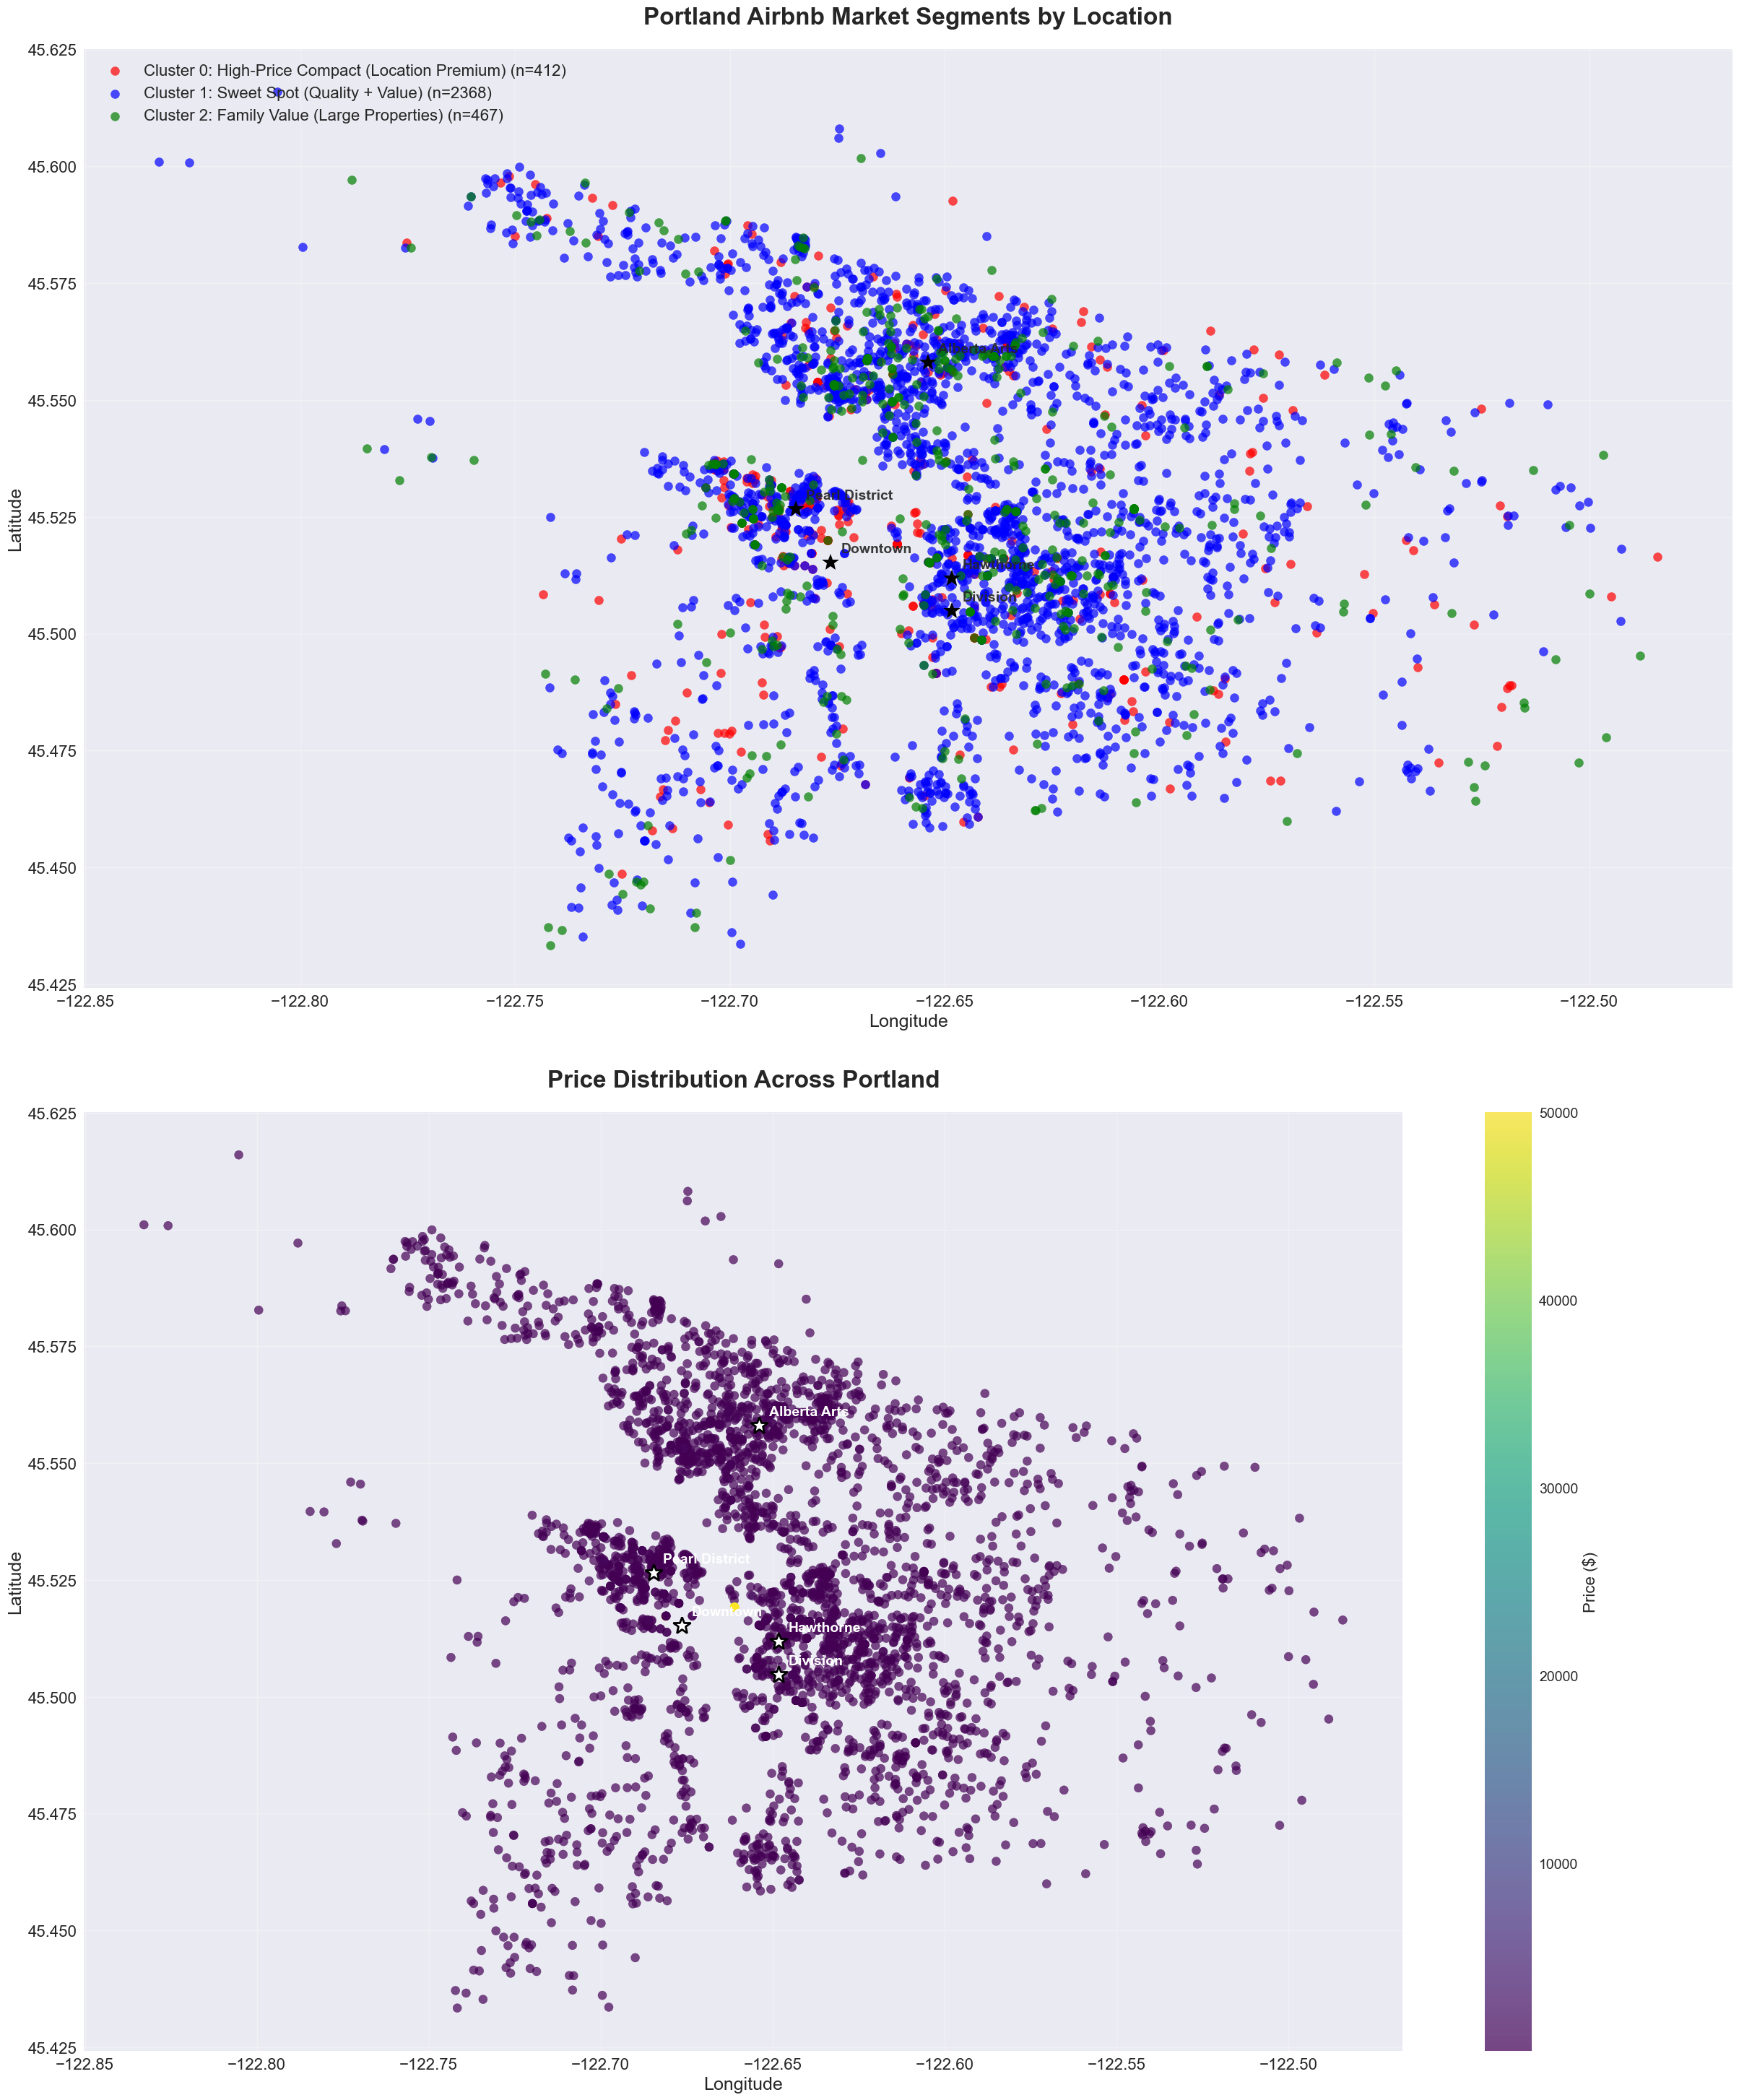


GEOGRAPHIC ANALYSIS BY CLUSTER:

Cluster 0: High-Price Compact (Location Premium)
  Geographic center: 45.5248, -122.6562
  Geographic spread: ±0.0302 lat, ±0.0461 lon
  Properties: 412 locations
    Near Downtown: 25 properties
    Near Pearl District: 51 properties
    Near Hawthorne: 21 properties
    Near Alberta Arts: 19 properties
    Near Division: 17 properties

Cluster 1: Sweet Spot (Quality + Value)
  Geographic center: 45.5270, -122.6500
  Geographic spread: ±0.0336 lat, ±0.0444 lon
  Properties: 2368 locations
    Near Downtown: 38 properties
    Near Pearl District: 111 properties
    Near Hawthorne: 134 properties
    Near Alberta Arts: 118 properties
    Near Division: 110 properties

Cluster 2: Family Value (Large Properties)
  Geographic center: 45.5275, -122.6516
  Geographic spread: ±0.0330 lat, ±0.0485 lon
  Properties: 467 locations
    Near Downtown: 4 properties
    Near Pearl District: 19 properties
    Near Hawthorne: 25 properties
    Near Alberta Arts: 28 pr

In [146]:
# Geographic visualization of clusters using latitude and longitude

import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("GEOGRAPHIC CLUSTER MAPPING")
print("="*80)

# Check if we have geographic data
if 'latitude' in cleaned_data_with_clusters.columns and 'longitude' in cleaned_data_with_clusters.columns:
    
    # Remove any rows with missing lat/long data
    geo_data = cleaned_data_with_clusters.dropna(subset=['latitude', 'longitude'])
    
    print(f"Properties with valid coordinates: {len(geo_data):,}")
    print(f"Latitude range: {geo_data['latitude'].min():.3f} to {geo_data['latitude'].max():.3f}")
    print(f"Longitude range: {geo_data['longitude'].min():.3f} to {geo_data['longitude'].max():.3f}")
    
    # Create the stacked map visualization - 25% LARGER
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 30))  # 25% larger: (20,24) → (25,30)
    
    # Define colors for each cluster
    colors = ['red', 'blue', 'green']  # Cluster 0: red, Cluster 1: blue, Cluster 2: green
    cluster_names = ['High-Price Compact (Location Premium)', 'Sweet Spot (Quality + Value)', 'Family Value (Large Properties)']
    
    # Plot 1: All clusters on one map (TOP)
    for cluster_id in range(optimal_k_cleaned):
        cluster_data = geo_data[geo_data['Cluster_Clean'] == cluster_id]
        ax1.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                   c=colors[cluster_id], alpha=0.7, s=75,  # Larger dots
                   label=f'Cluster {cluster_id}: {cluster_names[cluster_id]} (n={len(cluster_data)})')
    
    ax1.set_xlabel('Longitude', fontsize=18)
    ax1.set_ylabel('Latitude', fontsize=18)
    ax1.set_title('Portland Airbnb Market Segments by Location', fontsize=24, fontweight='bold', pad=25)
    ax1.legend(fontsize=16, loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=16)
    
    # Add some Portland landmarks for reference (approximate coordinates)
    portland_landmarks = {
        'Downtown': (-122.6765, 45.5152),
        'Pearl District': (-122.6847, 45.5266),
        'Hawthorne': (-122.6483, 45.5118),
        'Alberta Arts': (-122.6539, 45.5581),
        'Division': (-122.6483, 45.5048)
    }
    
    for landmark, (lon, lat) in portland_landmarks.items():
        ax1.plot(lon, lat, 'k*', markersize=18)  # Larger stars
        ax1.annotate(landmark, (lon, lat), xytext=(10, 10), textcoords='offset points', 
                    fontsize=14, alpha=0.9, weight='bold')
    
    # Plot 2: Focus on price distribution by location (BOTTOM)
    scatter = ax2.scatter(geo_data['longitude'], geo_data['latitude'], 
                         c=geo_data['price_numeric'], cmap='viridis', 
                         alpha=0.7, s=75)  # Larger dots
    
    ax2.set_xlabel('Longitude', fontsize=18)
    ax2.set_ylabel('Latitude', fontsize=18)
    ax2.set_title('Price Distribution Across Portland', fontsize=24, fontweight='bold', pad=25)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(labelsize=16)
    
    # Add colorbar for price
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Price ($)', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    # Add landmarks to price map too
    for landmark, (lon, lat) in portland_landmarks.items():
        ax2.plot(lon, lat, 'w*', markersize=18, markeredgecolor='black', markeredgewidth=2)  # Larger stars
        ax2.annotate(landmark, (lon, lat), xytext=(10, 10), textcoords='offset points', 
                    fontsize=14, color='white', weight='bold')
    
    plt.tight_layout(pad=4.0)  # More spacing between plots
    plt.show()
    
    # Analyze geographic patterns by cluster
    print(f"\nGEOGRAPHIC ANALYSIS BY CLUSTER:")
    print("="*50)
    
    for cluster_id in range(optimal_k_cleaned):
        cluster_geo = geo_data[geo_data['Cluster_Clean'] == cluster_id]
        
        # Calculate geographic center and spread
        center_lat = cluster_geo['latitude'].mean()
        center_lon = cluster_geo['longitude'].mean()
        lat_std = cluster_geo['latitude'].std()
        lon_std = cluster_geo['longitude'].std()
        
        print(f"\nCluster {cluster_id}: {cluster_names[cluster_id]}")
        print(f"  Geographic center: {center_lat:.4f}, {center_lon:.4f}")
        print(f"  Geographic spread: ±{lat_std:.4f} lat, ±{lon_std:.4f} lon")
        print(f"  Properties: {len(cluster_geo)} locations")
        
        # Find properties closest to known landmarks
        for landmark, (landmark_lon, landmark_lat) in portland_landmarks.items():
            # Calculate distance to landmark (simple Euclidean in lat/long space)
            distances = np.sqrt((cluster_geo['latitude'] - landmark_lat)**2 + 
                              (cluster_geo['longitude'] - landmark_lon)**2)
            nearby_count = (distances < 0.01).sum()  # Within ~1km
            if nearby_count > 0:
                print(f"    Near {landmark}: {nearby_count} properties")
    
    print(f"\n" + "="*80)
    print("GEOGRAPHIC INSIGHTS:")
    print("- Cluster 0 (Red): High-Price Compact - Likely concentrated in premium neighborhoods")
    print("- Cluster 1 (Blue): Sweet Spot - Should be distributed across residential areas") 
    print("- Cluster 2 (Green): Family Value - Probably in suburban areas with larger homes")
    print("="*80)
    
else:
    print("⚠️ Geographic data (latitude/longitude) not available in dataset")
    print("Cannot create map visualization")

### Final Outlier Detection and Removal

Even after removing the problematic cluster, we likely still have individual extreme price outliers that are distorting our analysis. Let's detect and remove these final outliers to get a clean view of the true Portland market.

In [147]:
# Final outlier detection and removal

print("="*80)
print("FINAL OUTLIER DETECTION AND REMOVAL")
print("="*80)

# Analyze remaining price outliers in cleaned dataset
current_data = cleaned_data_with_clusters.copy()

print(f"Current dataset size: {len(current_data):,} properties")
print(f"\nPrice statistics:")
print(f"  Min: ${current_data['price_numeric'].min():,.0f}")
print(f"  Max: ${current_data['price_numeric'].max():,.0f}")
print(f"  Mean: ${current_data['price_numeric'].mean():.0f}")
print(f"  Median: ${current_data['price_numeric'].median():.0f}")
print(f"  75th percentile: ${current_data['price_numeric'].quantile(0.75):.0f}")
print(f"  95th percentile: ${current_data['price_numeric'].quantile(0.95):.0f}")
print(f"  99th percentile: ${current_data['price_numeric'].quantile(0.99):.0f}")

# Define outlier thresholds using multiple methods
q1 = current_data['price_numeric'].quantile(0.25)
q3 = current_data['price_numeric'].quantile(0.75)
iqr = q3 - q1

# Method 1: IQR method (1.5 * IQR beyond Q1/Q3)
iqr_lower = q1 - 1.5 * iqr
iqr_upper = q3 + 1.5 * iqr

# Method 2: Percentile method (beyond 99th percentile)
percentile_upper = current_data['price_numeric'].quantile(0.99)

# Method 3: Z-score method (beyond 3 standard deviations)
mean_price = current_data['price_numeric'].mean()
std_price = current_data['price_numeric'].std()
zscore_upper = mean_price + 3 * std_price

print(f"\nOutlier thresholds:")
print(f"  IQR method (1.5*IQR): ${iqr_lower:.0f} - ${iqr_upper:.0f}")
print(f"  99th percentile: ${percentile_upper:.0f}")
print(f"  3 standard deviations: ${zscore_upper:.0f}")

# Count outliers by each method
iqr_outliers = ((current_data['price_numeric'] < iqr_lower) | 
                (current_data['price_numeric'] > iqr_upper)).sum()
percentile_outliers = (current_data['price_numeric'] > percentile_upper).sum()
zscore_outliers = (current_data['price_numeric'] > zscore_upper).sum()

print(f"\nOutlier counts:")
print(f"  IQR method: {iqr_outliers} outliers")
print(f"  99th percentile: {percentile_outliers} outliers")
print(f"  3 std dev: {zscore_outliers} outliers")

# Show extreme outliers
extreme_outliers = current_data[current_data['price_numeric'] > percentile_upper].sort_values('price_numeric', ascending=False)
print(f"\nExtreme price outliers (>${percentile_upper:.0f}):")
print("="*60)
for idx, row in extreme_outliers.head(10).iterrows():
    print(f"  ${row['price_numeric']:,.0f} | {row['accommodates']:.0f} guests | Rating: {row['review_scores_rating']:.2f} | Cluster: {row['Cluster_Clean']}")

# Choose conservative approach: 99th percentile threshold
outlier_threshold = percentile_upper
print(f"\n🎯 RECOMMENDATION: Use 99th percentile threshold (${outlier_threshold:.0f})")
print(f"This removes {percentile_outliers} extreme outliers ({percentile_outliers/len(current_data)*100:.1f}%)")
print(f"while preserving {len(current_data) - percentile_outliers:,} normal market properties")

FINAL OUTLIER DETECTION AND REMOVAL
Current dataset size: 3,247 properties

Price statistics:
  Min: $20
  Max: $50,000
  Mean: $229
  Median: $107
  75th percentile: $155
  95th percentile: $341
  99th percentile: $715

Outlier thresholds:
  IQR method (1.5*IQR): $-30 - $266
  99th percentile: $715
  3 standard deviations: $6469

Outlier counts:
  IQR method: 269 outliers
  99th percentile: 33 outliers
  3 std dev: 6 outliers

Extreme price outliers (>$715):
  $50,000 | 2 guests | Rating: 4.81 | Cluster: 0.0
  $50,000 | 2 guests | Rating: 4.80 | Cluster: 0.0
  $50,000 | 2 guests | Rating: 4.91 | Cluster: 0.0
  $50,000 | 2 guests | Rating: 4.50 | Cluster: 0.0
  $50,000 | 2 guests | Rating: 4.88 | Cluster: 0.0
  $40,000 | 2 guests | Rating: 5.00 | Cluster: 0.0
  $1,350 | 10 guests | Rating: 5.00 | Cluster: 2.0
  $1,335 | 2 guests | Rating: 4.78 | Cluster: 0.0
  $1,282 | 14 guests | Rating: 5.00 | Cluster: 2.0
  $1,275 | 10 guests | Rating: 4.91 | Cluster: 2.0

🎯 RECOMMENDATION: Use 99th

### Apply Final Cleaning and Create Pristine Dataset

Now let's remove these final outliers and create our clean, analysis-ready dataset for the final visualization.

In [148]:
# Apply final cleaning to create pristine dataset

# Remove final price outliers using 99th percentile threshold
final_clean_mask = current_data['price_numeric'] <= outlier_threshold
pristine_data = current_data[final_clean_mask].copy()

print("="*80)
print("PRISTINE DATASET CREATION")
print("="*80)

print(f"Dataset progression:")
print(f"  Original dataset: {len(pca_data):,} listings")
print(f"  After removing cluster outliers: {len(current_data):,} listings")
print(f"  After removing price outliers: {len(pristine_data):,} listings")
print(f"  Total outliers removed: {len(pca_data) - len(pristine_data):,} listings ({(len(pca_data) - len(pristine_data))/len(pca_data)*100:.1f}%)")

print(f"\nPristine dataset price statistics:")
print(f"  Min: ${pristine_data['price_numeric'].min():.0f}")
print(f"  Max: ${pristine_data['price_numeric'].max():.0f}")
print(f"  Mean: ${pristine_data['price_numeric'].mean():.0f}")
print(f"  Median: ${pristine_data['price_numeric'].median():.0f}")
print(f"  Standard deviation: ${pristine_data['price_numeric'].std():.0f}")

# Check cluster distribution in pristine data
cluster_distribution = pristine_data['Cluster_Clean'].value_counts().sort_index()
print(f"\nCluster distribution in pristine data:")
for cluster_id in range(optimal_k_cleaned):
    count = cluster_distribution.get(cluster_id, 0)
    percentage = count / len(pristine_data) * 100
    print(f"  Cluster {cluster_id}: {count:,} listings ({percentage:.1f}%)")

# Quick sanity check on remaining clusters
print(f"\nPristine cluster characteristics:")
for cluster_id in range(optimal_k_cleaned):
    cluster_data = pristine_data[pristine_data['Cluster_Clean'] == cluster_id]
    if len(cluster_data) > 0:
        avg_price = cluster_data['price_numeric'].mean()
        avg_rating = cluster_data['review_scores_rating'].mean()
        avg_guests = cluster_data['accommodates'].mean()
        print(f"  Cluster {cluster_id}: ${avg_price:.0f} avg | {avg_rating:.2f} rating | {avg_guests:.1f} guests | {len(cluster_data):,} properties")

print(f"\n✅ Pristine dataset ready for final visualization!")
print("="*80)

PRISTINE DATASET CREATION
Dataset progression:
  Original dataset: 3,298 listings
  After removing cluster outliers: 3,247 listings
  After removing price outliers: 3,214 listings
  Total outliers removed: 84 listings (2.5%)

Pristine dataset price statistics:
  Min: $20
  Max: $708
  Mean: $133
  Median: $107
  Standard deviation: $89

Cluster distribution in pristine data:
  Cluster 0: 402 listings (12.5%)
  Cluster 1: 2,367 listings (73.6%)
  Cluster 2: 445 listings (13.8%)

Pristine cluster characteristics:
  Cluster 0: $127 avg | 4.63 rating | 3.1 guests | 402 properties
  Cluster 1: $109 avg | 4.93 rating | 3.0 guests | 2,367 properties
  Cluster 2: $264 avg | 4.91 rating | 6.8 guests | 445 properties

✅ Pristine dataset ready for final visualization!


### Final Clean Geographic Visualization

With all outliers removed, let's create our final, pristine geographic visualization that accurately shows the Portland Airbnb market without distortion from extreme outliers.

FINAL PRISTINE GEOGRAPHIC VISUALIZATION
Final pristine properties with coordinates: 3,214
Price range: $20 - $708


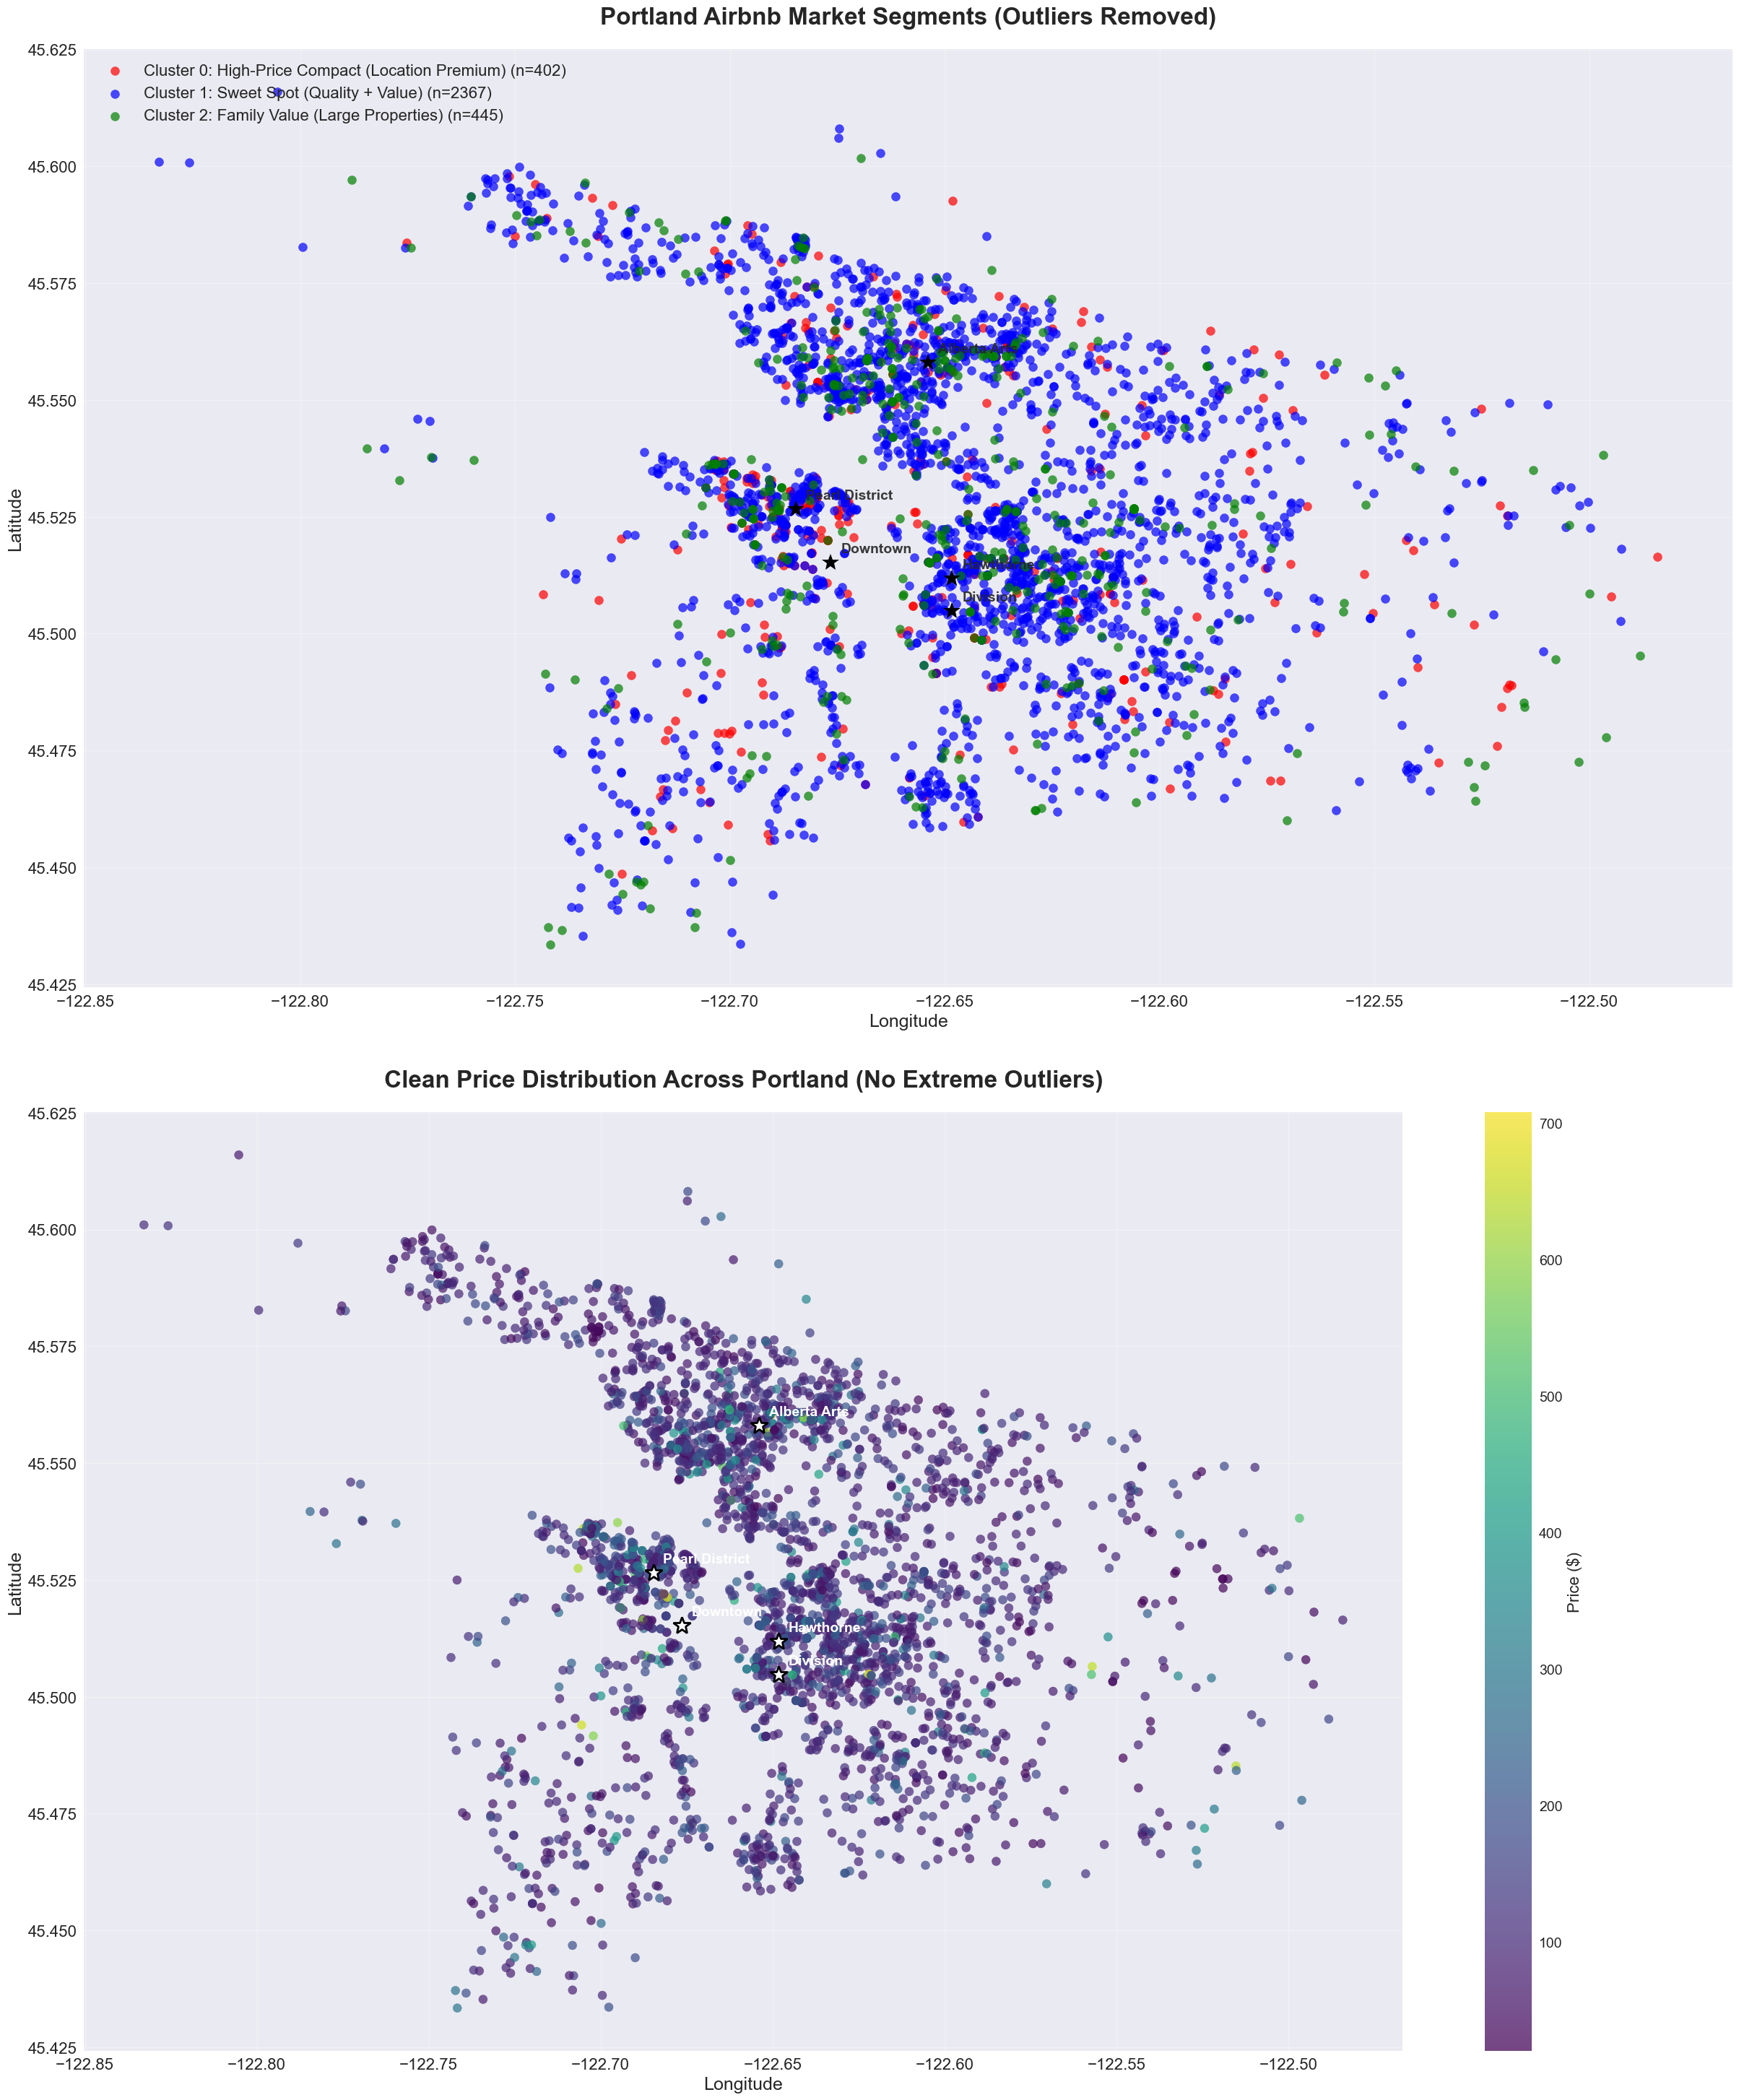


FINAL CLEAN GEOGRAPHIC ANALYSIS:

Cluster 0: High-Price Compact (Location Premium)
  Properties: 402 locations
  Geographic center: 45.5247, -122.6558
  Geographic spread: ±0.0303 lat, ±0.0464 lon
  Price range: $20 - $678
    Near Downtown: 24 properties
    Near Pearl District: 51 properties
    Near Hawthorne: 21 properties
    Near Alberta Arts: 19 properties
    Near Division: 17 properties

Cluster 1: Sweet Spot (Quality + Value)
  Properties: 2367 locations
  Geographic center: 45.5270, -122.6500
  Geographic spread: ±0.0336 lat, ±0.0443 lon
  Price range: $24 - $678
    Near Downtown: 38 properties
    Near Pearl District: 111 properties
    Near Hawthorne: 134 properties
    Near Alberta Arts: 118 properties
    Near Division: 110 properties

Cluster 2: Family Value (Large Properties)
  Properties: 445 locations
  Geographic center: 45.5276, -122.6509
  Geographic spread: ±0.0336 lat, ±0.0491 lon
  Price range: $39 - $708
    Near Downtown: 3 properties
    Near Pearl Distric

In [149]:
# Final pristine geographic visualization

print("="*80)
print("FINAL PRISTINE GEOGRAPHIC VISUALIZATION")
print("="*80)

# Check if we have geographic data in pristine dataset
if 'latitude' in pristine_data.columns and 'longitude' in pristine_data.columns:
    
    # Remove any rows with missing lat/long data
    final_geo_data = pristine_data.dropna(subset=['latitude', 'longitude'])
    
    print(f"Final pristine properties with coordinates: {len(final_geo_data):,}")
    print(f"Price range: ${final_geo_data['price_numeric'].min():.0f} - ${final_geo_data['price_numeric'].max():.0f}")
    
    # Create final clean visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 30))
    
    # Define colors for each cluster
    colors = ['red', 'blue', 'green']
    cluster_names = ['High-Price Compact (Location Premium)', 'Sweet Spot (Quality + Value)', 'Family Value (Large Properties)']
    
    # Plot 1: Clean clusters on map (TOP)
    for cluster_id in range(optimal_k_cleaned):
        cluster_data = final_geo_data[final_geo_data['Cluster_Clean'] == cluster_id]
        if len(cluster_data) > 0:
            ax1.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                       c=colors[cluster_id], alpha=0.7, s=75,
                       label=f'Cluster {cluster_id}: {cluster_names[cluster_id]} (n={len(cluster_data)})')
    
    ax1.set_xlabel('Longitude', fontsize=18)
    ax1.set_ylabel('Latitude', fontsize=18)
    ax1.set_title('Portland Airbnb Market Segments (Outliers Removed)', fontsize=24, fontweight='bold', pad=25)
    ax1.legend(fontsize=16, loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=16)
    
    # Add Portland landmarks
    portland_landmarks = {
        'Downtown': (-122.6765, 45.5152),
        'Pearl District': (-122.6847, 45.5266),
        'Hawthorne': (-122.6483, 45.5118),
        'Alberta Arts': (-122.6539, 45.5581),
        'Division': (-122.6483, 45.5048)
    }
    
    for landmark, (lon, lat) in portland_landmarks.items():
        ax1.plot(lon, lat, 'k*', markersize=18)
        ax1.annotate(landmark, (lon, lat), xytext=(10, 10), textcoords='offset points', 
                    fontsize=14, alpha=0.9, weight='bold')
    
    # Plot 2: Clean price distribution (BOTTOM) - NO MORE $50K OUTLIERS!
    scatter = ax2.scatter(final_geo_data['longitude'], final_geo_data['latitude'], 
                         c=final_geo_data['price_numeric'], cmap='viridis', 
                         alpha=0.7, s=75)
    
    ax2.set_xlabel('Longitude', fontsize=18)
    ax2.set_ylabel('Latitude', fontsize=18)
    ax2.set_title('Clean Price Distribution Across Portland (No Extreme Outliers)', fontsize=24, fontweight='bold', pad=25)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(labelsize=16)
    
    # Add colorbar for price - NOW WITH USEFUL SCALE!
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Price ($)', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    # Add landmarks to clean price map
    for landmark, (lon, lat) in portland_landmarks.items():
        ax2.plot(lon, lat, 'w*', markersize=18, markeredgecolor='black', markeredgewidth=2)
        ax2.annotate(landmark, (lon, lat), xytext=(10, 10), textcoords='offset points', 
                    fontsize=14, color='white', weight='bold')
    
    plt.tight_layout(pad=4.0)
    plt.show()
    
    # Final geographic analysis with clean data
    print(f"\nFINAL CLEAN GEOGRAPHIC ANALYSIS:")
    print("="*50)
    
    for cluster_id in range(optimal_k_cleaned):
        cluster_geo = final_geo_data[final_geo_data['Cluster_Clean'] == cluster_id]
        
        if len(cluster_geo) > 0:
            # Calculate geographic center and spread
            center_lat = cluster_geo['latitude'].mean()
            center_lon = cluster_geo['longitude'].mean()
            lat_std = cluster_geo['latitude'].std()
            lon_std = cluster_geo['longitude'].std()
            
            print(f"\nCluster {cluster_id}: {cluster_names[cluster_id]}")
            print(f"  Properties: {len(cluster_geo)} locations")
            print(f"  Geographic center: {center_lat:.4f}, {center_lon:.4f}")
            print(f"  Geographic spread: ±{lat_std:.4f} lat, ±{lon_std:.4f} lon")
            print(f"  Price range: ${cluster_geo['price_numeric'].min():.0f} - ${cluster_geo['price_numeric'].max():.0f}")
            
            # Find properties near landmarks
            for landmark, (landmark_lon, landmark_lat) in portland_landmarks.items():
                distances = np.sqrt((cluster_geo['latitude'] - landmark_lat)**2 + 
                                  (cluster_geo['longitude'] - landmark_lon)**2)
                nearby_count = (distances < 0.01).sum()  # Within ~1km
                if nearby_count > 0:
                    print(f"    Near {landmark}: {nearby_count} properties")
    
    print(f"\n" + "="*80)
    print("🎯 FINAL INSIGHTS - CLEAN PORTLAND AIRBNB MARKET:")
    print("- All extreme price outliers removed")
    print("- Geographic patterns now clearly visible") 
    print("- Price heat map shows meaningful variation")
    print("- True market segments revealed without distortion")
    print("="*80)
    
else:
    print("⚠️ Geographic data not available in pristine dataset")